In [0]:
import numpy as np
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [2]:
df = pd.read_csv('file_for_code.csv')
df["Date"] = pd.to_datetime(df["Date"])
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["day"] = df["Date"].dt.day
df.dropna(axis=0 , inplace=True)
np.random.seed(7)
classes_req =  ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']
df = df[classes_req]  
target_names = ['chiller_state']
shift_days = 1
shift_steps = shift_days * 2 
df_targets = df[target_names].shift(-shift_steps)
x_data = df.values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_train_scaled
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
batch_size = 196   
sequence_length = 24 * 7 * 8
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
x_batch, y_batch = next(generator)
seq = x_batch[batch, :, signal]
seq = y_batch[batch, :, signal]
seq = y_batch[batch, :, signal]
validation_data = (np.expand_dims(x_scaler.fit_transform(x_test), axis=0),
                   np.expand_dims(y_scaler.transform(y_test), axis=0))
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))
warmup_steps = 50  
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse  
    
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [
             callback_checkpoint,
             callback_reduce_lr]
model.fit(x=generator,
          epochs=60,
          steps_per_epoch=512,
          validation_data=validation_data,
          callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
result = model.evaluate(x=np.expand_dims(x_scaler.fit_transform(x_test), axis=0),
                        y=np.expand_dims(y_scaler.transform(y_test), axis=0))
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
    


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         804864    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 805,377
Trainable params: 805,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
512/512 [==============================] - ETA: 0s - loss: 0.0644
Epoch 00001: val_loss improved from inf to 0.09424, saving model to checkpoint.keras
512/512 [==============================] - 342s 669ms/step - loss: 0.0644 - val_loss: 0.0942 - lr: 0.0010
Epoch 2/60
512/512 [==============================] - ETA: 0s - loss: 0.0350
Epoch 00002: val_loss did not improve from 0.09424

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
512/512 [=========================

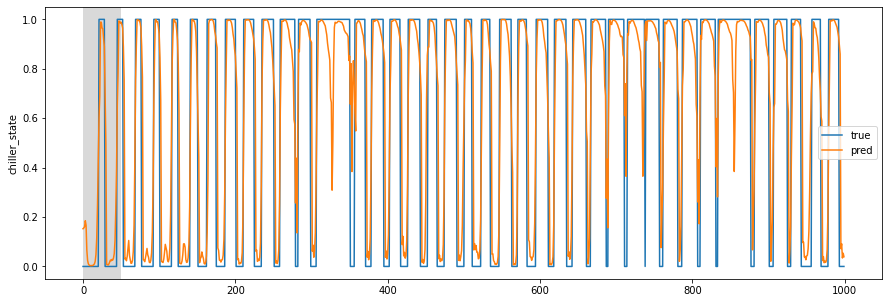

In [3]:
plot_comparison(start_idx=100, length=1000, train=True)

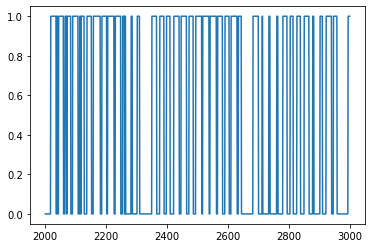

In [4]:
df['chiller_state'][2000:2000+1000].plot();

In [5]:
# testing the model results
y_test.shape
target_names = ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']
# steps for prediction
# create an array 
# a = []
# of values in order
# ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']

#        where time is the hour 
# example
array_example =  [ 7.  ,  26.6 ,  64.29,  29.4 ,  80.  , 573.  ,   1., 6,2017 ,4  ] 
x_scaler = MinMaxScaler()
array_example = x_scaler.fit_transform(np.array(array_example).reshape(-1,1))
array_example = np.reshape(array_example , (1,-1))     
array_example = np.expand_dims(array_example, axis=0)
y_pred = model.predict(array_example)    
actual_state_pred = y_pred.round()
int(actual_state_pred)

0

In [6]:
x =x_scaler.fit_transform(x_test)
x = np.expand_dims(x, axis=0)
y_true = y_test
y_true = np.squeeze(y_true)
y_pred = model.predict(x)
y_pred = np.squeeze(y_pred)
y_pred = y_pred.round()
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)

# precision 
precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

# recall
recall = recall_score(y_true,y_pred)
print('Recall: %f' % recall)

Accuracy: 0.863494
Precision: 0.895445
Recall: 0.843902


In [0]:
x =x_scaler.fit_transform(x_test[:])
x = np.expand_dims(x, axis=0)
y_true = y_test[:]
y_true = np.squeeze(y_true)
y_pred = model.predict(x)
y_pred = np.squeeze(y_pred)
y_pred = y_pred.round()
all_items = {'given_val_time_t': x_test[:][: , 6],
        'actual_state_time_t+2hr': y_true,
        'predicted_state_time_t+2hr' : y_pred
        }

df = pd.DataFrame(all_items, columns= ['given_val_time_t', 'actual_state_time_t+2hr' ,'predicted_state_time_t+2hr' ])
df.to_csv("output.csv" , index=True)

In [0]:
# The above was the mthod to get prediction 2hrs in the future

# note that 
# dont asume that since x,y have same index they are of same date, the data is modified such that 
# y is 2hr ahead of x
# for testing purposes and training aswell

In [0]:
# finding accurary precision recall 
# for this i will use a set of test samples

In [0]:
# GRU is used for now is because lstm is takes up alot of vram and basic functionality of both of these is same 
# GRU is slightly faster too 
# both these algos provide good functionality for time series data

In [0]:
# # amking the csv
# we can take an example set of 50 rows
# for checking the corrrectness of data 
# see row and row+24th row 

# since the data for tests is shifted by 24rows that is 1 day to predict the required 1 day in future
# u can see indexed row and indexed row +24Th row

# for example
# if we have data in first row , the same corresponding chiller state will be found in y_true with a +24 index